# WaveNet

In the last chapters we created a **multi-layer perceptron** character-level language model that received three previous characters and tried to predict the fourth character in a sequence. 

In this chapter we are going to **complexify this architecture** to take more characters in a sequence as an input. In addition, we are not going to feed them all into a single hidden layer because that squashes too much information too quickly. Instead, we are going to make a deeper model that progressively fuses this information to make its guess. Our model will look very much like a **WaveNet** introduced in the paper [DeepMind. (2016). *WaveNet: A generative model for raw audio*](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

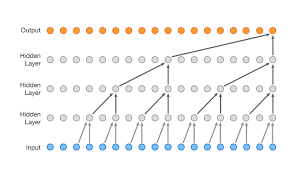

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(42); # seed rng for reproducibility

## Build dataset

In [3]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()

print(len(words))
print(words[:10])

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 8 # context length

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])   # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte,  Yte  = build_dataset(words[n2:])   # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


## Layers modules

In [7]:
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------

class Flatten:
    
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):

    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True)   # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [8]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

layers = [
  Embedding(vocab_size, n_embd),
  Flatten(), 
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 22097


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)    # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'Step:{i:7d} /{max_steps:7d}   Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break # DEBUG: break after a single iteration


Step:      0 / 200000   Loss: 3.2847


## Sequential container

A **sequential container** passes a given input through a list of layers sequentially. The use of a container will significantly simplify our code.

In [10]:
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [11]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(), 
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 22097


In [12]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01    # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'Step:{i:7d} /{max_steps:7d}   Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break # DEBUG: break after a single iteration

Step:      0 / 200000   Loss: 3.2825


# WaveNet architecture

We do not want to crush all the input characters to a single layer. We want to take two characters and fuse them (like a biagram representation). Then, we want to take these bigrams and fuse them (like a fourgram representation). Then, we fuse them again and so on. This way, we fuse the information from the previous context slowly into the network as it gets deeper.

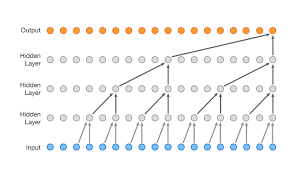

## Tensors shape

Let's explore the tensors shape during the forward pass.

In [13]:
print('Input:', tuple(Xb.shape))

for layer in model.layers:
    print('Output of', layer.__class__.__name__, 'layer:', tuple(layer.out.shape))

Input: (32, 8)
Output of Embedding layer: (32, 8, 10)
Output of Flatten layer: (32, 80)
Output of Linear layer: (32, 200)
Output of BatchNorm1d layer: (32, 200)
Output of Tanh layer: (32, 200)
Output of Linear layer: (32, 27)


## Linear layer

In the first linear layer what is happening:


*y = x @ w*

$$
\begin{bmatrix}
y_{1,1} & y_{1,2} & ... & y_{1,200}\\
y_{2,1} & y_{2,2} & ... & y_{2,200}\\
... & ... & ... & ... \\
y_{32,1} & y_{32,2} & ... & y_{32,200}
\end{bmatrix}
=
\begin{bmatrix}
x_{1,1} & x_{1,2} & ... & x_{1,80}\\
x_{2,1} & x_{2,2} & ... & x_{2,80}\\
... & ... & ... & ... \\
x_{32,1} & x_{32,2} & ... & x_{32,80}
\end{bmatrix}
\times
\begin{bmatrix}
w_{1,1} & w_{1,2} & ... & w_{1,200}\\
w_{2,1} & w_{2,2} & ... & w_{2,200}\\
... & ... & ... & ... \\
w_{80,1} & w_{80,2} & ... & w_{80,200}
\end{bmatrix}
$$

With random numbers:

In [14]:
(torch.randn(32, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([32, 200])

## Matrix multiplication over multiple dimensions

The input tensor does not have to be two dimensional. PyTorch performs **matrix multiplication on the last dimension** of the input tensor, and the dimensions before it are treated as a batch dimension.

We have 8 characters coming in for each example and we don't want to flatten them into a large 80 dimensional vector. For each example, we can make **4 groups of 2 characters each** and perform matrix multiplication over those bigram groups in parallel. 


$$
\begin{align*}

\begin{bmatrix}
y_{1,1,1} & y_{1,1,2} & ... & y_{1,1,200}\\
y_{1,2,1} & y_{1,2,2} & ... & y_{1,2,200}\\
y_{1,3,1} & y_{1,3,2} & ... & y_{1,3,200} \\
y_{1,4,1} & y_{1,4,2} & ... & y_{1,4,200}
\end{bmatrix}
&=
\begin{bmatrix}
x_{1,1,1} & x_{1,1,2} & ... & x_{1,1,20}\\
x_{1,2,1} & x_{1,2,2} & ... & x_{1,2,20}\\
x_{1,3,1} & x_{1,3,2} & ... & x_{1,3,20} \\
x_{1,4,1} & x_{1,4,2} & ... & x_{1,4,20}
\end{bmatrix}

\\

\begin{bmatrix}
y_{2,1,1} & y_{2,1,2} & ... & y_{2,1,200}\\
y_{2,2,1} & y_{2,2,2} & ... & y_{2,2,200}\\
y_{2,3,1} & y_{2,3,2} & ... & y_{2,3,200} \\
y_{2,4,1} & y_{2,4,2} & ... & y_{2,4,200}
\end{bmatrix}
&=
\begin{bmatrix}
x_{2,1,1} & x_{2,1,2} & ... & x_{2,1,20}\\
x_{2,2,1} & x_{2,2,2} & ... & x_{2,2,20}\\
x_{2,3,1} & x_{2,3,2} & ... & x_{2,3,20} \\
x_{2,4,1} & x_{2,4,2} & ... & x_{2,4,20}
\end{bmatrix}

\\

&\vdots

\\

\begin{bmatrix}
y_{32,1,1} & y_{32,1,2} & ... & y_{32,1,200}\\
y_{32,2,1} & y_{32,2,2} & ... & y_{32,2,200}\\
y_{32,3,1} & y_{32,3,2} & ... & y_{32,3,200} \\
y_{32,4,1} & y_{32,4,2} & ... & y_{32,4,200}
\end{bmatrix}
&=
\begin{bmatrix}
x_{32,1,1} & x_{32,1,2} & ... & x_{32,1,20}\\
x_{32,2,1} & x_{32,2,2} & ... & x_{32,2,20}\\
x_{32,3,1} & x_{32,3,2} & ... & x_{32,3,20} \\
x_{32,4,1} & x_{32,4,2} & ... & x_{32,4,20}
\end{bmatrix}

\end{align*}

\times
\begin{bmatrix}
w_{1,1} & w_{1,2} & ... & w_{1,200}\\
w_{2,1} & w_{2,2} & ... & w_{2,200}\\
... & ... & ... & ... \\
w_{20,1} & w_{20,2} & ... & w_{20,200}
\end{bmatrix}
$$

In [15]:
(torch.randn(32, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([32, 4, 200])

## FlattenConsecutive and BatchNorm1d layers

The **Flatten layer** takes as input a tensor of shape [32, 8, 10] and transforms it to a tensor if shape [32, 80]. Now, we want the flatten layer to transform it to a tensor of shape [32, 4, 20]. Hence, we will create the **FlattenConsecutive layer**.

In addition, we have to modify the implementation of the **BatchNorm1d layer** so it can take 2 dimensional or 3 dimensional tensors as input.

In [16]:
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):

    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True)   # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [17]:
n_embd = 24    # dimensionality of the character embedding vectors
n_hidden = 128 # number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 76579


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)   # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'Step:{i:7d} /{max_steps:7d}   Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Step:      0 / 200000   Loss: 3.3024


Step:  10000 / 200000   Loss: 2.1876
Step:  20000 / 200000   Loss: 2.0291
Step:  30000 / 200000   Loss: 2.0137
Step:  40000 / 200000   Loss: 1.6347
Step:  50000 / 200000   Loss: 1.5588
Step:  60000 / 200000   Loss: 1.8677
Step:  70000 / 200000   Loss: 1.8267
Step:  80000 / 200000   Loss: 2.2490
Step:  90000 / 200000   Loss: 2.4201
Step: 100000 / 200000   Loss: 1.9337
Step: 110000 / 200000   Loss: 2.1924
Step: 120000 / 200000   Loss: 1.5199
Step: 130000 / 200000   Loss: 1.8747
Step: 140000 / 200000   Loss: 2.2629
Step: 150000 / 200000   Loss: 1.9319
Step: 160000 / 200000   Loss: 1.7703
Step: 170000 / 200000   Loss: 1.9295
Step: 180000 / 200000   Loss: 1.7736
Step: 190000 / 200000   Loss: 1.8343


In [19]:
print('Input:', tuple(Xb.shape))

for layer in model.layers:
    print('Output of', layer.__class__.__name__, 'layer:', tuple(layer.out.shape))

Input: (32, 8)
Output of Embedding layer: (32, 8, 24)
Output of FlattenConsecutive layer: (32, 4, 48)
Output of Linear layer: (32, 4, 128)
Output of BatchNorm1d layer: (32, 4, 128)
Output of Tanh layer: (32, 4, 128)
Output of FlattenConsecutive layer: (32, 2, 256)
Output of Linear layer: (32, 2, 128)
Output of BatchNorm1d layer: (32, 2, 128)
Output of Tanh layer: (32, 2, 128)
Output of FlattenConsecutive layer: (32, 256)
Output of Linear layer: (32, 128)
Output of BatchNorm1d layer: (32, 128)
Output of Tanh layer: (32, 128)
Output of Linear layer: (32, 27)


**Note:**
- *view(-1, 1000)* stretches the tensor into rows of a 1,000 elements.
- *mean(1)* calculates the mean along the rows.

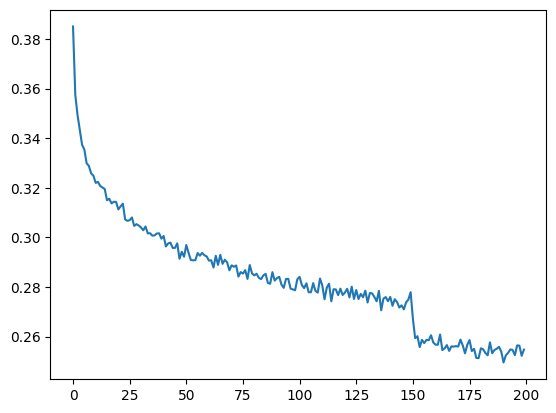

In [20]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [21]:
for layer in model.layers:
  layer.training = False # put layers into eval mode

In [22]:
@torch.no_grad()
def split_loss(split):

  # get x,y based on the split
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  # forward pass
  logits = model(x)
  loss = F.cross_entropy(logits, y)

  print(split, 'loss:', loss.item())

split_loss('train')
split_loss('val')

train loss: 1.7711459398269653
val loss: 1.9860286712646484


In [23]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...

    while True:

      # forward pass
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)

      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()

      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

sabrielle.
azetria.
sian.
raimen.
laron.
tyler.
jaliez.
kezan.
zoh.
elbertha.
legine.
amauri.
addell.
avajah.
milani.
jiliah.
fayto.
marino.
kodes.
chi.


In [27]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space